In [50]:
from xml.dom import minidom

import numpy as np
import pandas as pd

import joblib

from sklearn.decomposition import LatentDirichletAllocation

from tqdm import tqdm

In [3]:
# parse an xml file by name
file = minidom.parse('generated_character_words_prettyprint.xml')

In [6]:
# retrieve characters
characters = file.getElementsByTagName('character')

In [7]:
# create vocabulary

vocabulary = {}

for character in tqdm(characters):
    for word in character.getElementsByTagName('word'):
        attr = word.getAttribute('name')
        lemma = word.firstChild.data.lower()
        
        t = (attr, lemma)

        if t in vocabulary.keys():
            vocabulary[t] += 1
        else:
            vocabulary[t] = 1

print('Size of vocabulary: {}'.format(len(vocabulary)))

vocabulary_keys = list(vocabulary.keys())


100%|██████████| 182489/182489 [00:01<00:00, 106220.98it/s]


In [43]:
# generate bag of words for characters

def character_bow(words_list):
    bow = np.zeros(len(vocabulary_keys))
    for word in words_list:
        bow[vocabulary_keys.index(word)] += 1
    
    # do not standardize
    # bow = bow / bow.sum()
    return bow

In [44]:
# retrieve bag of words for each characters to generate training set

X = np.zeros([len(characters), len(vocabulary_keys)])

for idx, character in enumerate(tqdm(characters)):

    words_list = []

    for word in character.getElementsByTagName('word'):
        attr = word.getAttribute('name')
        lemma = word.firstChild.data.lower()

        words_list.append((attr, lemma))

    bow = character_bow(words_list=words_list)

    X[idx] = bow


100%|██████████| 182489/182489 [02:50<00:00, 1072.89it/s]


In [45]:
# instantiate latent dirichlet allocation model
lda = LatentDirichletAllocation(n_components=25, verbose=2, max_iter=10)

# train the model
lda.fit(X)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 1 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 2 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 3 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 4 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 5 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 6 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   59.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 7 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   59.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 8 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   59.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 9 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 10 of max_iter: 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   58.4s finished


LatentDirichletAllocation(n_components=25, verbose=2)

In [46]:
# get the result of classification
prob = lda.transform(X)

print(prob.shape)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


(182489, 25)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   58.1s finished


In [48]:


joblib.dump(lda, 'lda_model.gz')

['lda_model.gz']

In [47]:
prob

array([[0.008     , 0.008     , 0.008     , ..., 0.008     , 0.008     ,
        0.008     ],
       [0.00571429, 0.00571429, 0.00571429, ..., 0.00571429, 0.14859048,
        0.00571429],
       [0.0025    , 0.0025    , 0.0025    , ..., 0.43975776, 0.0025    ,
        0.0025    ],
       ...,
       [0.52      , 0.02      , 0.02      , ..., 0.02      , 0.02      ,
        0.02      ],
       [0.01333333, 0.01333333, 0.34666667, ..., 0.01333333, 0.01333333,
        0.01333333],
       [0.02      , 0.02      , 0.02      , ..., 0.02      , 0.02      ,
        0.02      ]])

In [51]:
df = {
    'name': [],
    'classification': []
}

for idx, character in enumerate(tqdm(characters)):
    name = character.getElementsByTagName('name')[0].firstChild.data
    classification = np.argmax(prob[idx])

    df['name'].append(name)
    df['classification'].append(classification)

df = pd.DataFrame(df)

100%|██████████| 182489/182489 [00:03<00:00, 58716.82it/s]


In [74]:
# save the dataframe
df.to_csv('classification_result.csv', index=False)

<AxesSubplot:xlabel='classification', ylabel='Count'>

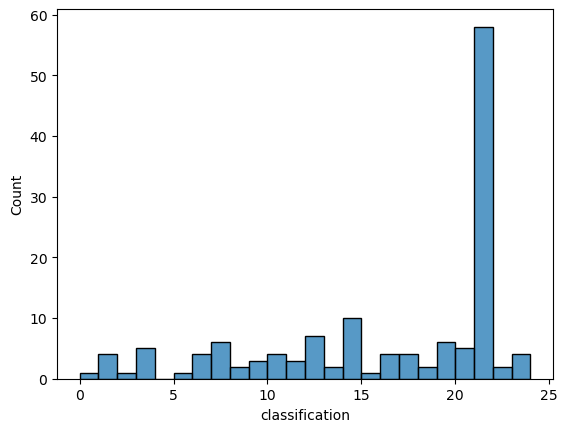

In [73]:
import seaborn as sns

sns.histplot(df[df['name'] == 'Hitler']['classification'], binwidth=1)